
# PyTorch Lightning DataModules

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-04-22T04:57:04.384956

This notebook will walk you through how to start using Datamodules. With the release of `pytorch-lightning` version 0.9.0, we have included a new class called `LightningDataModule` to help you decouple data related hooks from your `LightningModule`. The most up-to-date documentation on datamodules can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html).

---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/datamodules.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "pytorch-lightning>=1.4" "torchmetrics>=0.6" "torchvision" "ipython[notebook]" "torch>=1.6, <1.9"

## Introduction

First, we'll go over a regular `LightningModule` implementation without the use of a `LightningDataModule`

In [2]:
import os

import torch
import torch.nn.functional as F
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision import transforms

# Note - you must have torchvision installed for this example
from torchvision.datasets import CIFAR10, MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

/usr/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


[2022-04-22 05:20:10,901] [WARNING] [partition_parameters.py:53:<module>] unable to find torch.distributed._all_gather_base. will fall back to torch.distributed.all_gather which will result in suboptimal performance. please consider upgrading your pytorch installation.


### Defining the LitMNISTModel

Below, we reuse a `LightningModule` from our hello world tutorial that classifies MNIST Handwritten Digits.

Unfortunately, we have hardcoded dataset-specific items within the model,
forever limiting it to working with MNIST Data. 😢

This is fine if you don't plan on training/evaluating your model on different datasets.
However, in many cases, this can become bothersome when you want to try out your architecture with different datasets.

In [3]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # We hardcode dataset specific stuff here.
        self.data_dir = data_dir
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Build model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=128)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=128)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=128)

### Training the ListMNIST Model

In [4]:
model = LitMNIST()
trainer = Trainer(
    max_epochs=2,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)
trainer.fit(model)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.1 K
-------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Using DataModules

DataModules are a way of decoupling data-related hooks from the `LightningModule
` so you can develop dataset agnostic models.

### Defining The MNISTDataModule

Let's go over each function in the class below and talk about what they're doing:

1. ```__init__```
    - Takes in a `data_dir` arg that points to where you have downloaded/wish to download the MNIST dataset.
    - Defines a transform that will be applied across train, val, and test dataset splits.
    - Defines default `self.dims`, which is a tuple returned from `datamodule.size()` that can help you initialize models.


2. ```prepare_data```
    - This is where we can download the dataset. We point to our desired dataset and ask torchvision's `MNIST` dataset class to download if the dataset isn't found there.
    - **Note we do not make any state assignments in this function** (i.e. `self.something = ...`)

3. ```setup```
    - Loads in data from file and prepares PyTorch tensor datasets for each split (train, val, test).
    - Setup expects a 'stage' arg which is used to separate logic for 'fit' and 'test'.
    - If you don't mind loading all your datasets at once, you can set up a condition to allow for both 'fit' related setup and 'test' related setup to run whenever `None` is passed to `stage`.
    - **Note this runs across all GPUs and it *is* safe to make state assignments here**


4. ```x_dataloader```
    - `train_dataloader()`, `val_dataloader()`, and `test_dataloader()` all return PyTorch `DataLoader` instances that are created by wrapping their respective datasets that we prepared in `setup()`

In [5]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = PATH_DATASETS):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

### Defining the dataset agnostic `LitModel`

Below, we define the same model as the `LitMNIST` model we made earlier.

However, this time our model has the freedom to use any input data that we'd like 🔥.

In [6]:
class LitModel(LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.channels = channels
        self.width = width
        self.height = height
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Training the `LitModel` using the `MNISTDataModule`

Now, we initialize and train the `LitModel` using the `MNISTDataModule`'s configuration settings and dataloaders.

In [7]:
# Init DataModule
dm = MNISTDataModule()
# Init model from datamodule's attributes
model = LitModel(*dm.size(), dm.num_classes)
# Init trainer
trainer = Trainer(
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
)
# Pass the datamodule as arg to trainer.fit to override model hooks :)
trainer.fit(model, dm)

/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:158: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/home/AzDevOps_azpcontainer/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.1 K
-------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Defining the CIFAR10 DataModule

Lets prove the `LitModel` we made earlier is dataset agnostic by defining a new datamodule for the CIFAR10 dataset.

In [8]:
class CIFAR10DataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        self.dims = (3, 32, 32)
        self.num_classes = 10

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE)

### Training the `LitModel` using the `CIFAR10DataModule`

Our model isn't very good, so it will perform pretty badly on the CIFAR10 dataset.

The point here is that we can see that our `LitModel` has no problem using a different datamodule as its input data.

In [9]:
dm = CIFAR10DataModule()
model = LitModel(*dm.size(), dm.num_classes, hidden_size=256)
tqdm_progress_bar = TQDMProgressBar(refresh_rate=20)
trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    callbacks=[tqdm_progress_bar],
)
trainer.fit(model, dm)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Files already downloaded and verified


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 855 K 
-------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[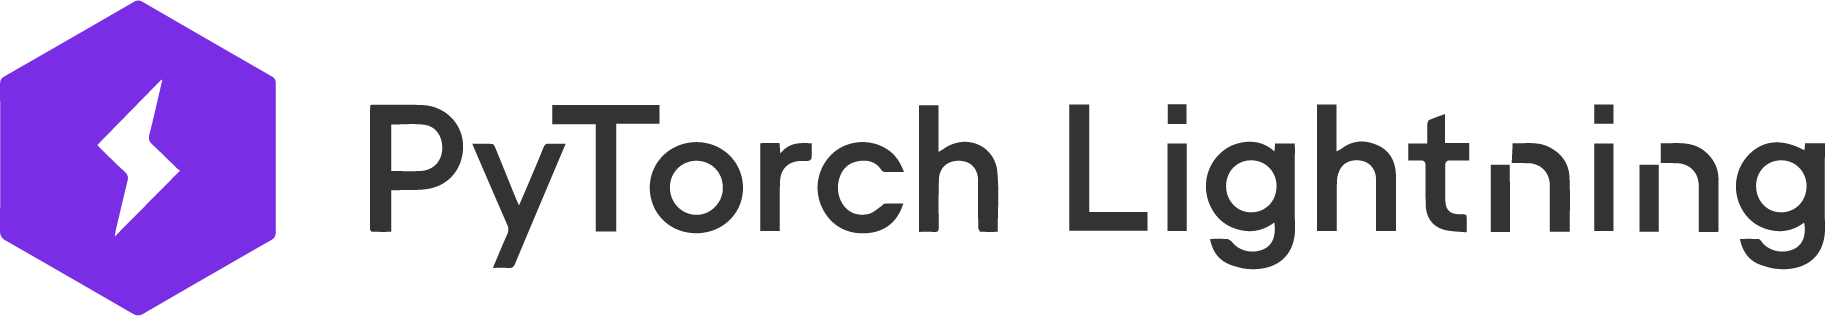{height="60px" width="240px"}](https://pytorchlightning.ai)